In [4]:
import os
# os.environ['CUDA_VISIBLE_DEVICES']='0'

import cv2
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image

import tensorflow as tf
from model_deeplab import *

### requirements

In [5]:
# !brew install ffmpeg
# !pip3 install ffmpeg ffprobe scikit-video pytube

In [6]:
# from pytube import YouTube
# url = "https://www.youtube.com/watch?v=G9ZM43ZpoCE" # Roger
# url = "https://www.youtube.com/watch?v=qAJLHBB5Js0" # Djokovic
# url = "https://www.youtube.com/watch?v=JA7G7AV-LT8" # Jordan
# url = "https://www.youtube.com/watch?v=qWtukUCglFs" # Aaron
# url = "https://www.youtube.com/watch?v=-ReOB8sZR4M" # solo
# yt = YouTube(url)
# yt.streams.first().download('/Users/cmchang/magic-effect/')

In [7]:
MODEL_NAME = 'mobilenetv2_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = 'model/'#tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

#@title Run on sample images {display-mode: "form"}

SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = ''  #@param {type:"string"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


In [8]:
def run_visualization(f, verbose=False):
    """Inferences DeepLab model and visualizes result."""
    try:
        if isinstance(f, str):
            original_im = Image.open(f)
        elif isinstance(f, np.ndarray):
            original_im = Image.fromarray(f)
    except:
        print("Unexpected error: invalid input")
        raise
    
#     print('running deeplab on image %s...' % f)
    resized_im, seg_map = MODEL.run(original_im)
    if verbose:
        vis_segmentation(resized_im, seg_map)
    return resized_im, seg_map

def find_cntr(cv2_img, n_max=5, th=1000):
    '''input: cv2_img = cv2.imread(img_path)'''
    '''output: mask '''
    b,g,r = cv2.split(cv2_img)  
    img = cv2.merge([r,g,b])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _,th2 = cv2.threshold(gray,10,1,cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(th2,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    areas = [-cv2.contourArea(contour) for contour in contours]
    num = max(n_max, np.sum(np.array(areas) < (-1)*th))
    return [contours[top] for top in np.argsort(areas)[:num]]

def get_stroke(person_mask, width=10):
    element = cv2.getStructuringElement(cv2.MORPH_RECT,(width,width))
    dilate = cv2.dilate(person_mask, element)
    result = cv2.absdiff(dilate, person_mask)
    retval, result = cv2.threshold(result, 0, 255, cv2.THRESH_BINARY)
    result_mask = np.stack((result/255.0,
                               result/255.0,
                               result/255.0), axis=2).astype(np.uint8)
    result_mask = cv2.medianBlur(result_mask, 1)
    return result_mask

def run_offset_effect(f, shift_x, shift_y):
    rgb, mask = run_visualization(f)
    rgb = np.array(rgb)
    fore = np.array(mask == 15, np.uint8) * 255
    fore = np.stack((fore, fore, fore),axis=2).astype(np.uint8)

    # find contours on person semantic mask
    k = find_cntr(fore)

    # select at most five contours
    num = min(len(k), 5)
    colors = [(252,141,98),(102,194,165), (141,160,203),(231,138,195),(166,216,84)]

    # combine all contours with different colors
    s = np.zeros(rgb.shape, np.uint8)
    for i in range(num):
        canvas = np.zeros(rgb.shape[0:2], np.uint8)
        one_mask = cv2.drawContours(canvas, k, i, (255,255,255),-1)
        color_fore = np.stack((one_mask / 255 * colors[i][0],
                               one_mask / 255 * colors[i][1],
                               one_mask / 255 * colors[i][2]), axis=2).astype(np.uint8)
        color_fore = get_shifted_image(color_fore, shift_x, shift_y).astype(np.uint8)
        s += color_fore
    s = s*(1-(fore>0))

    # combine with original images
    rgb_new = rgb*(1-(s>0)) + s
    return rgb, rgb_new

### Running

#### check step-by-step 

In [138]:
import skvideo.io
from skimage.transform import resize

filename = 'video_animation.mp4'
oriv = skvideo.io.vread(filename)
print(cap.shape)

(360, 720, 1280, 3)


In [139]:
colors = np.array([(252,141,98),(102,194,165), (141,160,203),(231,138,195),(166,216,84)]).astype(np.uint8)

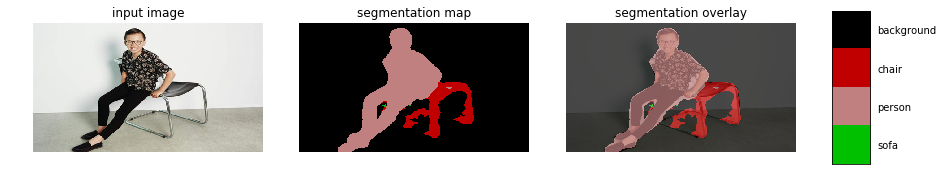

In [148]:
example = cv2.cvtColor(cv2.imread('image_kidmodel.jpg'), cv2.COLOR_BGR2RGB)
image = resize(example, (720, 1280)) * 255
image = image.astype(np.uint8)
_, person_mask = run_visualization(image, verbose=True)
person_mask = (person_mask == 15).astype(np.uint8)

In [149]:
person_mask = np.stack((person_mask, person_mask, person_mask), axis=2)

In [150]:
person_mask = resize(person_mask, (720, 1280)) * 255
person_mask = person_mask.astype(np.uint8)

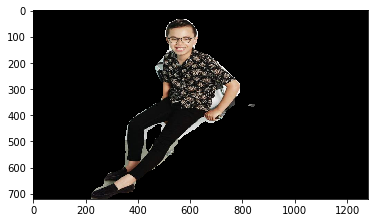

In [151]:
plt.imshow(image*(person_mask > 0))

In [152]:
import time
newv = list()
start_time = time.time()
for i in range(len(oriv)):
    print('{}/{}'.format(i, len(cap)), end='\r')
    j = i // (len(cap)//len(colors))
    temp = (np.mean(cap[i], axis=2) > 15).astype(np.uint8)
    mask = np.stack((temp, temp, temp), axis=2) * colors[j]
    mask = mask * (1-(person_mask > 0))
    newv.append(image * (1-(mask>0)) + mask)
newv = np.array(newv).astype(np.uint8)
print('time: {0:.3f}, output shape: {1}'.format(time.time()-start_time, newv.shape))    

time: 56.560, output shape: (360, 720, 1280, 3)


In [153]:
skvideo.io.vwrite(fname='animation-{}'.format(filename), videodata = newv, backend='ffmpeg', verbosity=1)

/usr/local/bin/ffmpeg -y -f rawvideo -pix_fmt rgb24 -s 1280x720 -i - /Users/cmchang/magic-effect/animation-video_animation.mp4


In [154]:
comp = np.concatenate((oriv, np.zeros(shape=(*oriv.shape[0:2], 10, 3), dtype=np.uint8), newv), axis=2)

In [155]:
skvideo.io.vwrite(fname='animation-compare-{}'.format(filename), videodata = comp, backend='ffmpeg', verbosity=1)

/usr/local/bin/ffmpeg -y -f rawvideo -pix_fmt rgb24 -s 2570x720 -i - /Users/cmchang/magic-effect/animation-compare-video_animation.mp4
